# Imports

In [1]:
import numpy as np
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

#### <font color='blue'> Put your imports here </font> 

In [56]:
## put yours imports here

# A. Load and process data

In [2]:
df = pd.read_csv('stack_traces.csv', index_col = [0])
df.head()

,typeStackTrace,stackTrace
0,java.lang.Throwable,class java.lang.Throwable : __trad__AABHQ29udH...
1,java.lang.Throwable,class java.lang.Throwable : __trad__AABUQ29udH...
2,java.lang.Throwable,class java.lang.Throwable : __trad__AABHQ29udH...
3,org.eclipse.swt.SWTException,class org.eclipse.swt.SWTException : Widget is...
4,java.lang.Throwable,class java.lang.Throwable : __trad__AABnQ29udH...


### <font color='red'> A.1. TO DO: Take only the most 500 frequent stack traces and load it into a new dataframe "df_distinct_stack_traces" </font>

### <font color='green'> A.1. Solution: (Provided) </font> 

In [3]:
n_unique_stack_traces = 500
df_distinct_stack_traces = pd.DataFrame()
df_distinct_stack_traces['stackTrace'] = df['stackTrace'].value_counts().index[:n_unique_stack_traces]
df_distinct_stack_traces.head()

,stackTrace
0,class java.lang.Exception : null\r\nat com.myC...
1,class java.lang.Exception : null\nat com.myCom...
2,class java.lang.Exception : null\nat com.myCom...
3,class java.lang.Exception : null\r\nat com.myC...
4,class java.lang.Exception : null\r\nat com.myC...


### <font color='red'> A.2.  TO DO: Parse all the stack traces into a list of frames and return the result as a new column "listFrames" in "df_distinct_stack_traces" </font>
#### **Hint:** to accelerate the process, use the function [pandas.DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html)

### <font color='green'> A.2. Solution: (Provided) </font> 

#### A.2.1. Parse the stack traces

In [4]:
'UTIL FUNCTIONS TO PARSE STACK TRACES'

# given a stack trace in a string format: return a dictionnary of information about the stack trace"
def extract_stack_traces_from_text(text):
    text = text.replace('\tat','at')
    text = text.replace(' at','\nat') 
    list_lines = text.split('\n')
    d_stack = dict()
    d_stack = extract_info_stack_traces(list_lines, d_stack) #extract all info about the stack trace
    return d_stack

def extract_info_stack_traces(list_lines, d_stack) :
    level = 0
    continu = False
    d_stack['is_truncated'] = False
    d_stack['level'] = level

    for i, line in enumerate(list_lines) :
        line = line.strip(' ')
          
        if re.search(r"Caused\s", line) :
            level += 1
            continu = True
            if re.search(r"[^\s]+\.+[\w\$\d\.]+(Exception)", line) :
                list_lines.insert(i+1, re.search(r"[^\s]+\.+[\w\$\d\.]+(Exception)", line).group())
            
            break 

        elif re.search(r"^at\s", line) :
            
            if re.search("\.\.\.\s[\d]+\smore", line):
                line = re.sub("\.\.\.\s[\d]+\smore",'', line)
                d_stack['is_truncated'] = True

            is_init = re.search("[^\s]*\.[\w\$\d]+\.\<init\>\([^)]*\)$", line)
            is_file = re.search("[^\s]*\.[\w\$\d]+\([^)]*\)", line)
            if is_init :
                l1 = re.sub(r'.\<init\>', '.ctor', is_init.group())
                if 'list_frames' in d_stack :
                    d_stack['list_frames'] = d_stack['list_frames'] + [re.sub(r'\([^)]*\)', '', l1)]

                else :
                    d_stack['list_frames'] = [re.sub(r'\([^)]*\)', '', l1)]

            elif is_file :
                if 'list_frames' in d_stack :
                    d_stack['list_frames'] = d_stack['list_frames'] + [re.sub(r'\([^)]*\)', '', is_file.group())]

                else :
                    d_stack['list_frames'] = [re.sub(r'\([^)]*\)', '', is_file.group())]

            else :
                d_stack['is_truncated'] = True
        
        elif re.search(r"[^\s]+\.+[\w\$\d\.]+(Exception)", line) :
            d_stack['type_exception'] = re.search(r"[^\s]+\.+[\w\$\d\.]+(Exception)", line).group()
    
    if continu :
        d_stack['caused_by'] = {}
        extract_info_stack_traces(list_lines[i+1:], d_stack['caused_by'])
        d_stack['level'] = d_stack['caused_by']['level'] + 1
    
    return d_stack

#extract all the frames (handle the case of Caused by) : 
def extract_all_list_frames_from_dict(d) :
    if d['level'] == 0 :
        return d['list_frames']
    else :
        if 'list_frames' in d['caused_by'] :
            return extract_all_list_frames_from_dict(d['caused_by']) + d['list_frames'] 
        else :
            return d['list_frames']

### Example 1

In [ ]:
stack_trace = df['stackTrace'][0]
dict_info_stack_trace = extract_stack_traces_from_text(stack_trace)
dict_info_stack_trace

{'is_truncated': True,
 'level': 0,
 'list_frames': ['com.myCompany.gpao.client.modules.atelier.poste.tools.dialogs.XMessageDialog.ctor',
  'com.myCompany.gpao.client.modules.atelier.poste.tools.dialogs.XMessageDialog.ctor',
  'com.myCompany.gpao.client.modules.atelier.poste.tools.dialogs.CtrlRecetteDialog.ctor',
  'com.myCompany.gpao.client.modules.atelier.poste.acq.InteractiveAcqQte.check',
  'com.myCompany.gpao.client.modules.atelier.poste.acq.UStockAcqStd.acquireQte',
  'com.myCompany.gpao.client.modules.atelier.poste.acces.ProdValidator_OF.corregraphy',
  'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.LotFromSelectionAdapter.selectLigne',
  'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.LotFromSelectionAdapter.selectLigne',
  'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.LotFromSelectionAdapter.selectLigne',
  'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.TableWrapper.valid',


In [ ]:
extract_all_list_frames_from_dict(dict_info_stack_trace)

['com.myCompany.gpao.client.modules.atelier.poste.tools.dialogs.XMessageDialog.ctor',
 'com.myCompany.gpao.client.modules.atelier.poste.tools.dialogs.XMessageDialog.ctor',
 'com.myCompany.gpao.client.modules.atelier.poste.tools.dialogs.CtrlRecetteDialog.ctor',
 'com.myCompany.gpao.client.modules.atelier.poste.acq.InteractiveAcqQte.check',
 'com.myCompany.gpao.client.modules.atelier.poste.acq.UStockAcqStd.acquireQte',
 'com.myCompany.gpao.client.modules.atelier.poste.acces.ProdValidator_OF.corregraphy',
 'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.LotFromSelectionAdapter.selectLigne',
 'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.LotFromSelectionAdapter.selectLigne',
 'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.LotFromSelectionAdapter.selectLigne',
 'com.myCompany.gpao.client.modules.atelier.poste.recette.wrappers.select.TableWrapper.valid',
 'com.myCompany.gpao.client.modules.atelier.poste.tools.cab.C

### Example 2

In [6]:
stack_trace = df['stackTrace'][57]
dict_info_stack_trace = extract_stack_traces_from_text(stack_trace)
dict_info_stack_trace

{'is_truncated': False,
 'level': 2,
 'type_exception': 'com.myCompany.core.exceptions.InfologicRuntimeException',
 'list_frames': ['com.myCompany.infoc.client.forms.results.ResultsPart.export',
  'com.myCompany.infoc.client.forms.results.ResultsPart.performExcelExport',
  'com.myCompany.infoc.client.forms.results.ResultsPart$2.run',
  'org.eclipse.jface.action.Action.runWithEvent',
  'org.eclipse.jface.action.ActionContributionItem.handleWidgetSelection',
  'org.eclipse.jface.action.ActionContributionItem.access$2',
  'org.eclipse.jface.action.ActionContributionItem$4.handleEvent',
  'org.eclipse.swt.widgets.EventTable.sendEvent',
  'org.eclipse.swt.widgets.Widget.sendEvent',
  'org.eclipse.swt.widgets.Display.runDeferredEvents',
  'org.eclipse.swt.widgets.Display.readAndDispatch',
  'org.eclipse.jface.window.Window.runEventLoop',
  'org.eclipse.jface.window.Window.open',
  'com.myCompany.core.client.Application.run',
  'com.myCompany.superviseur.client.SuperviseurApp.main'],
 'caused

In [7]:
extract_all_list_frames_from_dict(dict_info_stack_trace)

['com.myCompany.infoc.engine.export.ExcelResultExporter.export',
 'com.myCompany.infoc.client.forms.results.ResultsPart$ExportRunner.run',
 'org.eclipse.jface.operation.ModalContext$ModalContextThread.run',
 'com.myCompany.infoc.client.forms.results.ResultsPart.export',
 'com.myCompany.infoc.client.forms.results.ResultsPart.performExcelExport',
 'com.myCompany.infoc.client.forms.results.ResultsPart$2.run',
 'org.eclipse.jface.action.Action.runWithEvent',
 'org.eclipse.jface.action.ActionContributionItem.handleWidgetSelection',
 'org.eclipse.jface.action.ActionContributionItem.access$2',
 'org.eclipse.jface.action.ActionContributionItem$4.handleEvent',
 'org.eclipse.swt.widgets.EventTable.sendEvent',
 'org.eclipse.swt.widgets.Widget.sendEvent',
 'org.eclipse.swt.widgets.Display.runDeferredEvents',
 'org.eclipse.swt.widgets.Display.readAndDispatch',
 'org.eclipse.jface.window.Window.runEventLoop',
 'org.eclipse.jface.window.Window.open',
 'com.myCompany.core.client.Application.run',
 'co

#### A.2.2. Use the lambda function in the pandas apply to return the list of stack traces in a serie

In [5]:
df_distinct_stack_traces['listStackTrace'] = df_distinct_stack_traces['stackTrace'].apply(lambda x : extract_all_list_frames_from_dict(extract_stack_traces_from_text(x)))
df_distinct_stack_traces.head()

,stackTrace,listStackTrace
0,class java.lang.Exception : null\r\nat com.myC...,[com.myCompany.core.client.Application.createE...
1,class java.lang.Exception : null\nat com.myCom...,[com.myCompany.core.client.Application.createE...
2,class java.lang.Exception : null\nat com.myCom...,[com.myCompany.core.client.Application.createE...
3,class java.lang.Exception : null\r\nat com.myC...,[com.myCompany.core.client.Application.createE...
4,class java.lang.Exception : null\r\nat com.myC...,[com.myCompany.core.client.Application.createE...


# B. Compute all similarities between all stack trace pairs w.r.t. all similarity metrics

### <font color='red'> TO DO: For each similarity measure, implement a function that caluclates the similarity value between two stack traces." </font>
### <font color='red'> TO DO: Compute the similarities between all possible stack trace pairs while paralleling the computational process and using the minimum of storage (only the index) </font>
### <font color='red'> TO DO: Provide statistics about the similarity values: </font>
    - Distribution graph
    - Min value
    - Max value
    - Mean value
    - Median
    - Standard deviation
    - Variance
    |--------------------|-----------|-----------|------------|--------|------|----------|
    | Similarity measure | Min value | Max value | Mean value | Median | STD  | Variance |
    |--------------------|-----------|-----------|------------|--------|------|----------|
    |       Jaccard      |    0.0    |    1.0    |    0.17    |  0.13  | 0.19 |   0.04   |
    |--------------------|-----------|-----------|------------|--------|------|----------|
    |     Cosine BOW     |           |           |            |        |      |          |
    |--------------------|-----------|-----------|------------|--------|------|----------|
    |    Cosine TF-IDF   |           |           |            |        |      |          |
    |--------------------|-----------|-----------|------------|--------|------|----------|
    |   Cosine Bi-gram   |           |           |            |        |      |          |
    |--------------------|-----------|-----------|------------|--------|------|----------|
    |     Levenshtein    |           |           |            |        |      |          |
    |--------------------|-----------|-----------|------------|--------|------|----------|
    |         PDM        |           |           |            |        |      |          |
    |--------------------|-----------|-----------|------------|--------|------|----------|
    |      TraceSIM      |           |           |            |        |      |          |
    |--------------------|-----------|-----------|------------|--------|------|----------|

#### **Hint1:** Use the function [pandas.DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) twice for the column "listStackTrace" as illustrated in the diagram below
#### **Hint2:** create a new dataframe "df_measures" where its columns are (index_stack_trace_1, index_stack_trace_2, jaccard_values, cosine_bow_values, cosine_tfidf_values, ...)

### <font color='green'> **Solution**: (To complete ...) </font> 
**The solution is <font color='green'>provided</font> exclusively for the jaccard coefficient**

In [6]:
'UTIL FUNCTIONS TO HELP'
def get_index_sim(n_stacks, index_1, index_2) :
    return int(((2*n_stacks - (index_1+1)) * index_1) / 2 + (index_2 - index_1) -1)

def get_indexes_sim(n_stacks, index_similarity) :
    
    if index_similarity < n_stacks - 1 :
        return (0, index_similarity + 1)   
    
    else :
        lower_bound = int(n_stacks - 1.5 - math.sqrt((n_stacks - 1.5)**2 - 2*(index_similarity - n_stacks + 1)))
        upper_bound = int(n_stacks - 0.5 - math.sqrt((n_stacks - 0.5)**2 - 2*index_similarity)) + 1
        
        tmp = lower_bound
        continu = True
        while continu :
            if ((2*n_stacks - (tmp+1)) * tmp) / 2 <= index_similarity :
                a = tmp
                tmp += 1
            
            else : 
                continu = False
            
        return (a, int(index_similarity - (((2*n_stacks - (a+1)) * a) / 2) + a + 1))
    
def rowIndex(row):
    return row.name

In [7]:
#create new dataframe to store the similarity values w.r.t. the similarity measure
df_measures = pd.DataFrame(index = np.arange(int(n_unique_stack_traces * (n_unique_stack_traces-1) /2)))
df_measures['index_stack_trace_1'] = df_measures.index.to_series().apply(lambda x : get_indexes_sim(n_unique_stack_traces, x)[0])
df_measures['index_stack_trace_2'] = df_measures.index.to_series().apply(lambda x : get_indexes_sim(n_unique_stack_traces, x)[1])
df_measures

,index_stack_trace_1,index_stack_trace_2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
124745,496,498
124746,496,499
124747,497,498
124748,497,499


## B.1. Jaccard Coefficient [[doc](https://en.wikipedia.org/wiki/Jaccard_index)]

In [8]:
def jaccard (l1, l2) :
    s1 = set(l1)
    s2 = set(l2)
    similarity = float(len(s1.intersection(s2)) / len(s1.union(s2)))
    return similarity

def jaccard_df(s, s_copy, index) :
    return s_copy.apply(lambda x : jaccard(x, s)).tolist()[index+1:]

### Testing

In [9]:
"The output must be ~ 0.83 "
list_stack_1 = df_distinct_stack_traces['listStackTrace'][0]
list_stack_2 = df_distinct_stack_traces['listStackTrace'][1]
jaccard(list_stack_1, list_stack_2)

0.8333333333333334

In [10]:
%%time
# With paralleling the computational process
df_distinct_stack_traces['jaccard_similarities'] = df_distinct_stack_traces.apply(lambda x : jaccard_df(x['listStackTrace'], df_distinct_stack_traces['listStackTrace'], rowIndex(x)), axis = 1)
df_distinct_stack_traces['jaccard_similarities']

Wall time: 1.38 s


0      [0.8333333333333334, 0.8333333333333334, 0.833...
1      [1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, ...
2      [1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, ...
3      [1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.833...
4      [1.0, 0.8333333333333334, 1.0, 1.0, 0.83333333...
                             ...                        
495               [0.0, 0.08333333333333333, 0.2, 0.875]
496                      [0.0, 0.10344827586206896, 0.0]
497           [0.14705882352941177, 0.08333333333333333]
498                                                [0.2]
499                                                   []
Name: jaccard_similarities, Length: 500, dtype: object

In [11]:
df_measures['jaccard_values'] = pd.Series([elt for l in df_distinct_stack_traces['jaccard_similarities'] for elt in l])
df_measures

,index_stack_trace_1,index_stack_trace_2,jaccard_values
0,0,1,0.833333
1,0,2,0.833333
2,0,3,0.833333
3,0,4,0.833333
4,0,5,0.833333
...,...,...,...
124745,496,498,0.103448
124746,496,499,0.000000
124747,497,498,0.147059
124748,497,499,0.083333


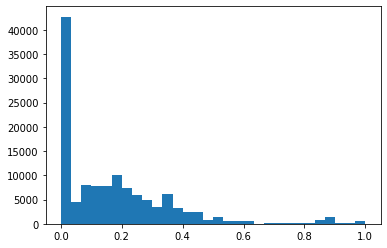

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['jaccard_values'], 30, alpha = 1, density = False)
plt.show()

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
# With for loop method
list_jaccard_values = []
'Complete your code here ..............'
for i in range(len(df_distinct_stack_traces)):
    for j in range(i+1, len(df_distinct_stack_traces)):
        vect_1 = df_distinct_stack_traces['listStackTrace'][i]
        vect_2 = df_distinct_stack_traces['listStackTrace'][j]
        list_jaccard_values.append(jaccard(vect_1, vect_2))

# With for loop method
#list_jaccard_values = []

#for i in range(len(df_measures)):
#    list_jaccard_values.append(df_measures['jaccard_values'][i])        


In [ ]:
'Assert the values are correct'
assert df_measures['jaccard_values'].equals(pd.Series(list_jaccard_values))

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
import statistics

'Complete your code here ............................ and print statistics'

print('The min values is:', round(min(list_jaccard_values),2))
print('The max values is:', round(max(list_jaccard_values),2))
print('The mean values is:', round(statistics.mean(list_jaccard_values),2))
print('The median values is:', round(statistics.median(list_jaccard_values),2))
print('The std values is:', round(np.std(list_jaccard_values),2))
print('The variance values is:', round(np.var(list_jaccard_values),2)) 

The min values is: 0.0
The max values is: 1.0
The mean values is: 0.17
The median values is: 0.13
The std values is: 0.19
The variance values is: 0.04


## B.2. Cosine BOW [[doc](https://en.wikipedia.org/wiki/Cosine_similarity)]

#### **Hint1:** U need to form a matrix "matrix_of_frames" where lines are stack traces and columns (features) are all the distinct frames, hence, the matrix values indicate the frequency of a particular frame in a given stack trace

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
'Complete your code here ...'
matrix_of_frames = []
all_distinct_frames = []

for i in range(n_unique_stack_traces):
    for j in range(len(df_distinct_stack_traces['listStackTrace'][i])):
        if df_distinct_stack_traces['listStackTrace'][i][j] not in all_distinct_frames:
            all_distinct_frames.append(df_distinct_stack_traces['listStackTrace'][i][j])

zeroed_counter = {frame: 0 for frame in all_distinct_frames}
# Each row will carry a copy of this 0-count dictionary

matrix_of_frames = [zeroed_counter.copy() for _ in df_distinct_stack_traces['listStackTrace']]

for stack_trace, stack_trace_count in zip(df_distinct_stack_traces['listStackTrace'], matrix_of_frames):
    # Iterating over each individual listStackTrace and its corresponding count dictionary
    for frame in stack_trace:
        stack_trace_count[frame] += 1

df_matrix_of_frames = pd.DataFrame(data = matrix_of_frames, columns = all_distinct_frames)
df_matrix_of_frames

#for i in range(n_unique_stack_traces):
#    row = []
#    for j in range(len(all_distinct_frames)):
#        row.append(df_distinct_stack_traces['listStackTrace'][i].count(all_distinct_frames[j]))
#    matrix_of_frames.append(row)    

#df_matrix_of_frames = pd.DataFrame(data = matrix_of_frames, columns = all_distinct_frames)
#df_matrix_of_frames    


,com.myCompany.core.client.Application.createErrorDialog,com.myCompany.core.client.Application.access$3,com.myCompany.core.client.Application$6.run,org.eclipse.swt.widgets.RunnableLock.run,org.eclipse.swt.widgets.Synchronizer.runAsyncMessages,org.eclipse.swt.widgets.Display.runAsyncMessages,org.eclipse.swt.widgets.Display.readAndDispatch,org.eclipse.jface.window.Window.runEventLoop,org.eclipse.jface.window.Window.open,com.myCompany.core.client.Application.run,...,com.myCompany.infoc.engine.charts.Charts.createData,com.myCompany.infoc.services.infocentre.tableaubord.HighchartsGenerator.buildChartOptions,com.myCompany.infoc.client.forms.results.html.HtmlComponent.setChart,com.myCompany.superviseur.client.drivers.lectcab.LectCab$$Lambda$160/10277112.keyTraversed,com.myCompany.superviseur.services.preparation.prepprep.impl.PrepPrepServiceImpl$$EnhancerByCGLIB$$39e02ed1.CGLIB$registerMouvementInTransaction$0$14,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$131/8916001.run,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$132/24367863.run,com.myCompany.core.client.modules.tables.LabelProvider.getColumnImage,com.myCompany.core.client.modules.tables.TableCellRenderer.toImage,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$133/26709830.run
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,1,1,0
498,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


#### <font color='blue'> Complete your own code here ...  </font> 

In [17]:
'Implement the functions'
from numpy.linalg import norm

def cosine_similarity(vect1, vect2):
	return np.dot(vect1,vect2)/(norm(vect1)*norm(vect2))

def cosine_similarity_df(s, s_copy, index) :
    return s_copy.apply(lambda x: cosine_similarity(x, s), axis=1).tolist()[index+1:]

In [ ]:
"The output must be ~ 0.90 "
vect_stack_1 = df_matrix_of_frames.iloc[0]
vect_stack_2 = df_matrix_of_frames.iloc[1]
cosine_similarity(vect_stack_1, vect_stack_2)


0.9090909090909091

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
'Complete your code here ..............'

# With parallelizing the computational process
df_distinct_stack_traces['cosine_bow_similarities'] = df_matrix_of_frames.apply(lambda x: cosine_similarity_df(x, df_matrix_of_frames, rowIndex(x)), axis=1)
df_distinct_stack_traces['cosine_bow_similarities']

0      [0.9090909090909091, 0.9090909090909091, 0.909...
1      [1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, ...
2      [1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, ...
3      [1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 0.909...
4      [1.0, 0.9090909090909091, 1.0, 1.0, 0.90909090...
                             ...                        
495    [0.0, 0.125, 0.27777777777777785, 0.9444444444...
496                       [0.0, 0.2773500981126146, 0.0]
497                          [0.2916666666666667, 0.125]
498                                [0.27777777777777785]
499                                                   []
Name: cosine_bow_similarities, Length: 500, dtype: object

In [ ]:
df_measures['cosine_bow_values'] = pd.Series([elt for l in df_distinct_stack_traces['cosine_bow_similarities'] for elt in l])
df_measures

,index_stack_trace_1,index_stack_trace_2,jaccard_values,cosine_bow_values
0,0,1,0.833333,0.909091
1,0,2,0.833333,0.909091
2,0,3,0.833333,0.909091
3,0,4,0.833333,0.909091
4,0,5,0.833333,0.909091
...,...,...,...,...
124745,496,498,0.103448,0.277350
124746,496,499,0.000000,0.000000
124747,497,498,0.147059,0.291667
124748,497,499,0.083333,0.125000


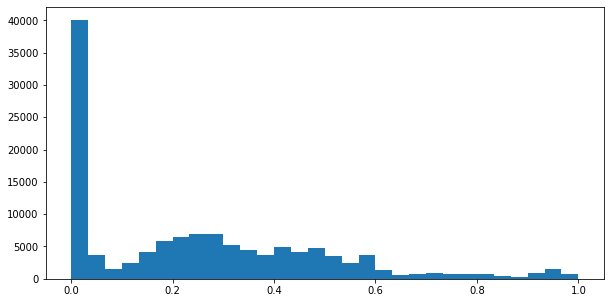

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['cosine_bow_values'] , 30, alpha = 1, density = False)
plt.show()

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
# With for loop method
list_cosine_bow_values = []
'Complete your code here ..............'
for i in range(len(df_distinct_stack_traces)):
    for j in range(i+1, len(df_distinct_stack_traces)):
        vect_1 = df_matrix_of_frames.iloc[i]
        vect_2 = df_matrix_of_frames.iloc[j]
        list_cosine_bow_values.append(cosine_similarity(vect_1, vect_2))

#'Complete your code here ..............'
#for i in range(len(df_measures)):
#    list_cosine_bow_values.append(df_measures['cosine_bow_values'][i])

KeyboardInterrupt: 

In [ ]:
'Assert the values are correct'
assert df_measures['cosine_bow_values'].equals(pd.Series(list_cosine_bow_values))

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
import statistics

'Complete your code here ............................ and print statistics'

print('The min values is:', round(min(list_cosine_bow_values),2))
print('The max values is:', round(max(list_cosine_bow_values),2))
print('The mean values is:', round(statistics.mean(list_cosine_bow_values),2))
print('The median values is:', round(statistics.median(list_cosine_bow_values),2))
print('The std values is:', round(np.std(list_cosine_bow_values),2))
print('The variance values is:', round(np.var(list_cosine_bow_values),2)) 

The min values is: 0.0
The max values is: 1.0
The mean values is: 0.25
The median values is: 0.22
The std values is: 0.25
The variance values is: 0.06


## B.3. Cosine TF-IDF [[doc](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)]


#### **Hint1:** U need to form a matrix "matrix_of_frames_tfidf" where lines are stack traces and columns (features) are all the distinct frames, BUT, the matrix values indicate the TF-IDF (not frequency) of a particular frame in a given stack trace

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the tokenized vocabulary manually
def dummy_fun(doc):
    return doc
tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None) 
 
# List of the 500 stacktraces frames
list_all_stacktaces = []
for i in range(n_unique_stack_traces):
    list_all_stacktaces.append(df_distinct_stack_traces['listStackTrace'][i]) 

# Learn the vocabulary
tfidf.fit(list_all_stacktaces)

TfidfVectorizer(preprocessor=<function dummy_fun at 0x000001B808DE16C0>,
                token_pattern=None,
                tokenizer=<function dummy_fun at 0x000001B808DE16C0>)

In [ ]:
'Complete your code here ..............'
tfidf_values = tfidf.fit_transform(list_all_stacktaces)
matrix_of_frames_tfidf = tfidf_values.toarray()
df_matrix_of_frames_tfidf = pd.DataFrame(data = matrix_of_frames_tfidf, columns = tfidf.vocabulary_)
df_matrix_of_frames_tfidf


,com.myCompany.core.client.Application.createErrorDialog,com.myCompany.core.client.Application.access$3,com.myCompany.core.client.Application$6.run,org.eclipse.swt.widgets.RunnableLock.run,org.eclipse.swt.widgets.Synchronizer.runAsyncMessages,org.eclipse.swt.widgets.Display.runAsyncMessages,org.eclipse.swt.widgets.Display.readAndDispatch,org.eclipse.jface.window.Window.runEventLoop,org.eclipse.jface.window.Window.open,com.myCompany.core.client.Application.run,...,com.myCompany.infoc.engine.charts.Charts.createData,com.myCompany.infoc.services.infocentre.tableaubord.HighchartsGenerator.buildChartOptions,com.myCompany.infoc.client.forms.results.html.HtmlComponent.setChart,com.myCompany.superviseur.client.drivers.lectcab.LectCab$$Lambda$160/10277112.keyTraversed,com.myCompany.superviseur.services.preparation.prepprep.impl.PrepPrepServiceImpl$$EnhancerByCGLIB$$39e02ed1.CGLIB$registerMouvementInTransaction$0$14,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$131/8916001.run,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$132/24367863.run,com.myCompany.core.client.modules.tables.LabelProvider.getColumnImage,com.myCompany.core.client.modules.tables.TableCellRenderer.toImage,com.myCompany.superviseur.client.modules.postpreparation.otprep.tache.OTPrepTache$$Lambda$133/26709830.run
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.424099,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.182298,0.0,0.0,0.0,0.0,0.0,0.199397,0.199397
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [ ]:
"The output must be ~ 0.87"
vect_stack_1 = df_matrix_of_frames_tfidf.iloc[0]
vect_stack_2 = df_matrix_of_frames_tfidf.iloc[1]
cosine_similarity(vect_stack_1, vect_stack_2)

0.8688203192015255

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
'Complete your code here ..............'
# With paralleling the computational process
df_distinct_stack_traces['cosine_tfidf_similarities'] = df_matrix_of_frames_tfidf.apply(lambda x: cosine_similarity_df(x, df_matrix_of_frames_tfidf, rowIndex(x)), axis=1)
df_distinct_stack_traces['cosine_tfidf_similarities']

0      [0.8688203192015255, 0.8688203192015255, 0.868...
1      [1.0, 1.0, 1.0, 1.0, 0.8688203192015255, 1.0, ...
2      [1.0, 1.0, 1.0, 0.8688203192015255, 1.0, 1.0, ...
3      [1.0, 1.0, 0.8688203192015255, 1.0, 1.0, 0.868...
4      [1.0, 0.8688203192015255, 1.0, 1.0, 0.86882031...
                             ...                        
495    [0.0, 0.017133699314021276, 0.0615320670077773...
496                       [0.0, 0.3052568018879289, 0.0]
497          [0.06068615608481797, 0.017133699314021276]
498                               [0.061532067007777386]
499                                                   []
Name: cosine_tfidf_similarities, Length: 500, dtype: object

In [ ]:
df_measures['cosine_tfidf_values'] = pd.Series([elt for l in df_distinct_stack_traces['cosine_tfidf_similarities'] for elt in l])
df_measures

,index_stack_trace_1,index_stack_trace_2,jaccard_values,cosine_bow_values,cosine_tfidf_values
0,0,1,0.833333,0.909091,0.868820
1,0,2,0.833333,0.909091,0.868820
2,0,3,0.833333,0.909091,0.868820
3,0,4,0.833333,0.909091,0.868820
4,0,5,0.833333,0.909091,0.868820
...,...,...,...,...,...
124745,496,498,0.103448,0.277350,0.305257
124746,496,499,0.000000,0.000000,0.000000
124747,497,498,0.147059,0.291667,0.060686
124748,497,499,0.083333,0.125000,0.017134


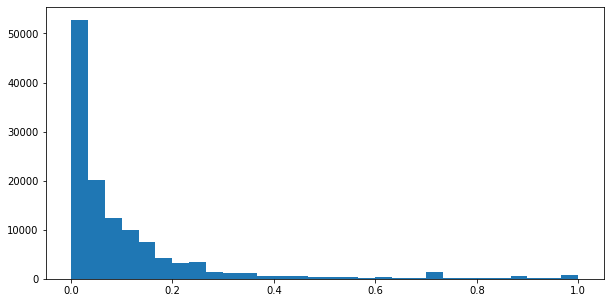

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['cosine_tfidf_values'], 30, alpha = 1, density = False)
plt.show()

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
%%time
# With for loop method
list_cosine_tfidf_values = []
'Complete your code here ..............'

for i in range(len(df_distinct_stack_traces)):
    for j in range(i+1, len(df_distinct_stack_traces)):
        vect_1 = df_matrix_of_frames_tfidf.iloc[i]
        vect_2 = df_matrix_of_frames_tfidf.iloc[j]
        list_cosine_tfidf_values.append(cosine_similarity(vect_1, vect_2))

Wall time: 16.2 s


In [ ]:
'Assert the values are correct'
assert df_measures['cosine_tfidf_values'].equals(pd.Series(list_cosine_tfidf_values))

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
import statistics

'Complete your code here ............................ and print statistics'

print('The min values is:', round(min(list_cosine_tfidf_values),2))
print('The max values is:', round(max(list_cosine_tfidf_values),2))
print('The mean values is:', round(statistics.mean(list_cosine_tfidf_values),2))
print('The median values is:', round(statistics.median(list_cosine_tfidf_values),2))
print('The std values is:', round(np.std(list_cosine_tfidf_values),2))
print('The variance values is:', round(np.var(list_cosine_tfidf_values),2)) 

The min values is: 0.0
The max values is: 1.0
The mean values is: 0.1
The median values is: 0.05
The std values is: 0.17
The variance values is: 0.03


## B.4. Cosine Bi-gram[[doc](https://en.wikipedia.org/wiki/N-gram)]


#### **Hint1:** U need to form a matrix "matrix_of_frames_bigram" where lines are stack traces and columns (features) are all the distinct bigram-frames and the matrix values indicate the frequency of a particular bigram-frame in a given stack trace

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
# CountVectorizer()
# .fitTransform()

In [8]:
# List all all distinct frames
all_distinct_frames = []

for i in range(n_unique_stack_traces):
    for j in range(len(df_distinct_stack_traces['listStackTrace'][i])):
        if df_distinct_stack_traces['listStackTrace'][i][j] not in all_distinct_frames:
            all_distinct_frames.append(df_distinct_stack_traces['listStackTrace'][i][j])

# List of all bigram frames
all_bigram_frames = []
for i in range(len(all_distinct_frames)):
    for j in range(i+1,len(all_distinct_frames)):
        # all_bigram_frames.append(str([all_distinct_frames[i],all_distinct_frames[j]]))
        all_bigram_frames.append(str([i,j]))

# Index the bigram frames
all_bigram_frames_indexed = {}
keys = range(len(all_bigram_frames))
for i in keys:
    all_bigram_frames_indexed[i] = str(all_bigram_frames[i])  

Because it takes too long to run, instead of having as columns the real bigrams of frames that would contain a list of the 2 string bigrams, we decided to index the bigram with a number that would represent the column in the matrix.

In [9]:
# First value of the frame of the bigram with the index index_bigram
def get_first_value_bigram(index_bigram):
    return all_distinct_frames[eval(all_bigram_frames_indexed[index_bigram])[0]]
# Second value of the frame of the bigram with the index index_bigram
def get_second_value_bigram(index_bigram):
    return all_distinct_frames[eval(all_bigram_frames_indexed[index_bigram])[1]]
# List with the string value of the bigram of index index_bigram
def get_bigram_value(index_bigram):
    return [get_first_value_bigram(index_bigram), get_second_value_bigram(index_bigram)]     
# Count the occurences of the bigram in the list
def count_occurences_bigram(bigram, list):
    occ_1 = list.count(bigram[0])
    occ_2 = list.count(bigram[1])
    return min(occ_1,occ_2)      

In [14]:
matrix_of_frames_bigram_indexed = []

for i in range(n_unique_stack_traces):
    listStrackTrace = df_distinct_stack_traces['listStackTrace'][i]
    row = []
    for j in range(len(all_bigram_frames)):
        row.append(count_occurences_bigram(get_bigram_value(j),listStrackTrace))
    matrix_of_frames_bigram_indexed.append(row)


In [15]:
df_matrix_of_bigram_frames_indexed = pd.DataFrame(data = matrix_of_frames_bigram_indexed, columns = range(len(matrix_of_frames_bigram_indexed[0])))
df_matrix_of_bigram_frames_indexed

,0,1,2,3,4,5,6,7,8,9,...,689715,689716,689717,689718,689719,689720,689721,689722,689723,689724
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
for i in range(len(df_matrix_of_bigram_frames_indexed[0])):
    if df_matrix_of_bigram_frames_indexed[0][i] != df_matrix_of_bigram_frames_indexed[1][i]:
        print(False)


In [28]:
"The output must be ~ 0.9 "
vect_stack_1 = df_matrix_of_bigram_frames_indexed[0]
vect_stack_2 = df_matrix_of_bigram_frames_indexed[1]
cosine_similarity(vect_stack_1, vect_stack_2)

1.0000000000000002

#### !!! TO DO 

In [ ]:
'Complete your code here ..............'
matrix_of_frames_bigram = ?
df_matrix_of_frames_bigram = pd.DataFrame(data = matrix_of_frames_bigram, columns = ?)

In [ ]:
"The output must be ~ 0.9 "
vect_stack_1 = df_matrix_of_frames_bigram.iloc[0]
vect_stack_2 = df_matrix_of_frames_bigram.iloc[1]
cosine_similarity(vect_stack_1, vect_stack_2)

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
%%time
# With paralleling the computational process
'Complete your code here ..............'
df_distinct_stack_traces['cosine_bigram_similarities'] = df_matrix_of_bigram_frames_indexed.apply(lambda x: cosine_similarity_df(x, df_matrix_of_frames_tfidf, rowIndex(x)), axis=1)
df_distinct_stack_traces['cosine_bigram_similarities']

In [ ]:
df_measures['cosine_bigram_values'] = pd.Series([elt for l in df_distinct_stack_traces['cosine_bigram_similarities'] for elt in l])
df_measures

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['cosine_bigramvalues'], 30, alpha = 1, density = False)
plt.show()

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
# With for loop method
list_cosine_bigram_values = []
'Complete your code here ..............'

In [ ]:
'Assert the values are correct'
assert df_measures['cosine_bigram_values'].equals(pd.Series(list_cosine_bigram_values))

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
'Complete your code here ............................ and print statistics'

print('The min values is:',)
print('The max values is:', )
print('The mean values is:', )
print('The median values is:', )
print('The std values is:', )
print('The variance values is:',) 

## B.5. Levenshtein similarity [[doc](https://en.wikipedia.org/wiki/Levenshtein_distance)]


#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
'Implement the functions'
def levenshtein_similarity (list1, list2) :
    'Complete your code here ..............'
    return similarity

def levenshtein_df(s, s_copy, index) :
    'Complete your code here ..............'

In [ ]:
"The output must be ~ 0.9"
list_stack_1 = df_distinct_stack_traces['listStackTrace'][0]
list_stack_2 = df_distinct_stack_traces['listStackTrace'][1]
levenshtein_similarity(list_stack_1, list_stack_2)

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
%%time
'Complete your code here ..............'
# With paralleling the computational process
df_distinct_stack_traces['levenshtein_similarities'] = ?
df_distinct_stack_traces['levenshtein_similarities']

In [ ]:
df_measures['levenshtein_values'] = pd.Series([elt for l in df_distinct_stack_traces['levenshtein_similarities']  for elt in l])
df_measures

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['levenshtein_values'], 30, alpha = 1, density = False)
plt.show()

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
# With for loop method
list_levenshtein_values = []
'Complete your code here ..............'

In [ ]:
'Assert the values are correct'
assert df_measures['levenshtein_values'].equals(pd.Series(list_levenshtein_values))

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
'Complete your code here ............................ and print statistics'

print('The min values is:',)
print('The max values is:', )
print('The mean values is:', )
print('The median values is:', )
print('The std values is:', )
print('The variance values is:',) 

## B.6. PDM - Rebucket [[Paper](https://www.researchgate.net/publication/254041628_ReBucket_A_method_for_clustering_duplicate_crash_reports_based_on_call_stack_similarity)]

NOTES:

TODO: replace the PDM similarity

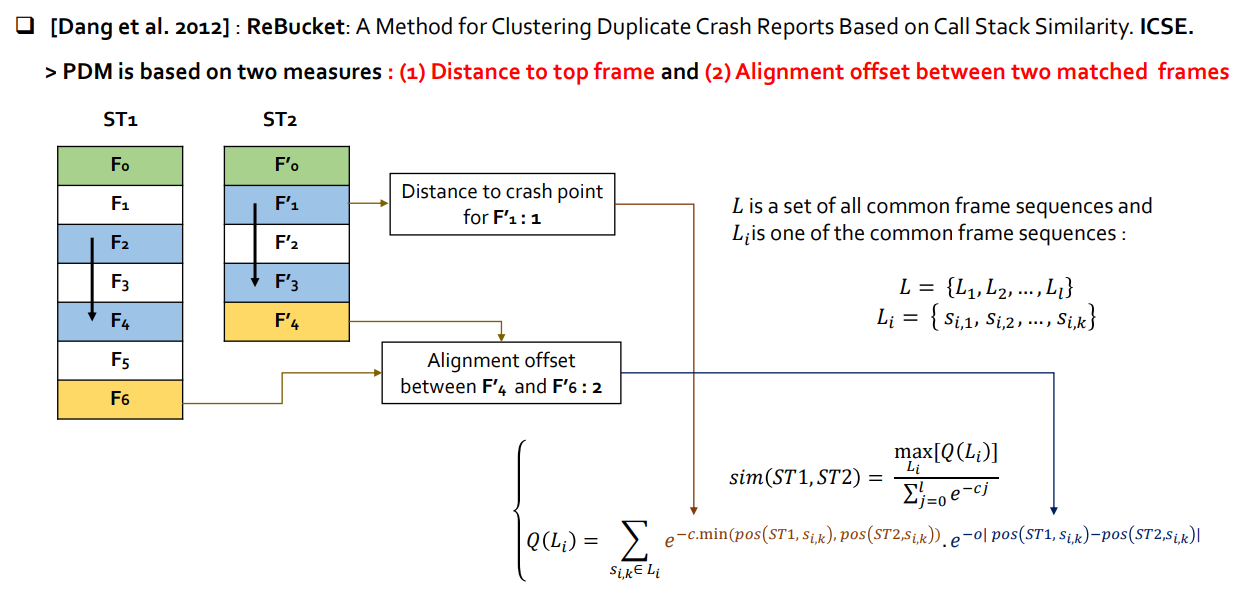

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
'Implement the functions'
def pdm_similarity(stack1, stack2, c, o):

    stack_len1 = len(stack1)
    stack_len2 = len(stack2)
    if stack_len1 == stack_len2 :
        equal = True
        i = 0
        while equal and i < stack_len1   :
            if stack1[i] == stack2[i] :
                i += 1
            else :
                equal = False
        
    if (stack_len1 == stack_len2) and equal :
        return 1
    else :
        M = [[0. for i in range(stack_len2 + 1)] for j in range(stack_len1 + 1)]

        for i in range(1, stack_len1 + 1):
            for j in range(1, stack_len2 + 1):
                if stack1[i - 1] == stack2[j - 1]:
                    x = 'Complete your code here ...............'
                else:
                    x = 'Complete your code here ...............'
                M[i][j] = 'Complete your code here ...............'
        sig = 0.
        for i in range(min(stack_len1, stack_len2) + 1):
            sig += 'Complete your code here ...............'
        sim = 'Complete your code here ...............'
        return sim
    
def pdm_df(s, s_copy, index, c, o) :
    'Complete your code here ...............'

In [ ]:
"The output must be ~ 0.9"
list_stack_1 = df_distinct_stack_traces['listStackTrace'][0]
list_stack_2 = df_distinct_stack_traces['listStackTrace'][1]
pdm_similarity(list_stack_1, list_stack_2, c= 0.1, o = 0.1)

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
%%time
'Complete your code here ..............'
# With paralleling the computational process
df_distinct_stack_traces['pdm_similarities'] = ?
df_distinct_stack_traces['pdm_similarities']

In [ ]:
df_measures['pdm_values'] = pd.Series([elt for l in df_distinct_stack_traces['pdm_similarities']  for elt in l])
df_measures

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['pdm_values'], 30, alpha = 1, density = False)
plt.show()

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
%%time
# With for loop method
list_pdm_values = []
'Complete your code here ..............'

In [ ]:
'Assert the values are correct'
assert df_measures['pdm_values'].equals(pd.Series(list_pdm_values))

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
'Complete your code here ............................ and print statistics'

print('The min values is:',)
print('The max values is:', )
print('The mean values is:', )
print('The median values is:', )
print('The std values is:', )
print('The variance values is:',) 

## B.7. TraceSIM [[Paper](https://arxiv.org/pdf/2009.12590.pdf)]

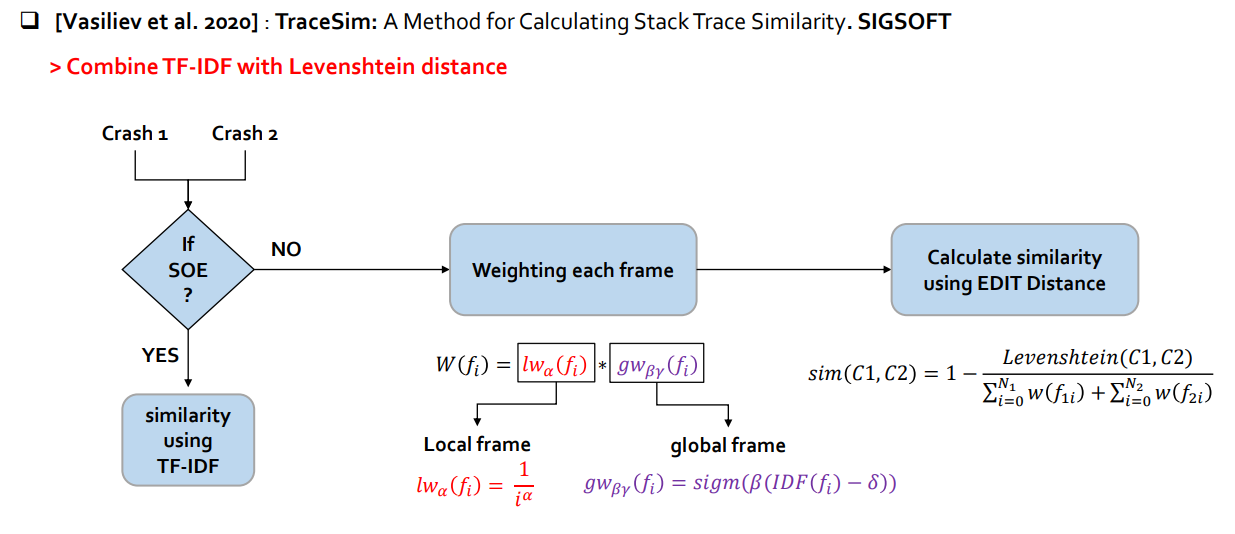

#### **Hint1:** U need to form a dictionnary where the keys are the distinct frames and the values are IDF
#### Use the formula : $idf(\text{frame}) = 1 + log(\frac{\text{number of stack traces}}{\text{number of stack traces that contains the frame}})$

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
'Complete your code here .................'
dict_idf_frames = ?
dict_idf_frames['com.mycompany.achats.services.commande.impl.commandeserviceimpl.load']

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
def traceSim_similarity(stack1, stack2, dict_idf_frames, alpha, beta, gamma):
    
    stack1 = [process_frame(frame) for frame in stack1]
    stack2 = [process_frame(frame) for frame in stack2]
    
    stack1_weights = get_weight_stack(stack1, dict_idf_frames, alpha, beta, gamma)
    stack2_weights = get_weight_stack(stack2, dict_idf_frames, alpha, beta, gamma)
    
    max_dist = sum(stack1_weights) + sum(stack2_weights)
    dist = levenshtein_dist_weights(stack1, stack1_weights, stack2, stack2_weights)
    sim = 0 if max_dist == 0 else 1 - dist / max_dist
    return sim


def traceSim_df(df_row, df_copy, index, dict_idf_frames, alpha = 0.5, beta = 1, gamma = 0) :
    'Complete your code here .........................'

def process_frame(frame) :
    frame = frame.lower()
    frame = frame.replace('$','')
    frame = frame.replace('/','')
    frame = frame.replace('<','')
    frame = frame.replace('>','')
    return frame

def get_weight_stack(stack, dict_idf_frames, alpha, beta, gamma) :

    local_weights = [1 / (1 + i) ** alpha for i, _ in enumerate(stack)]
    global_weights = []
    'Complete your code here .........................'
    return [lw * gw for lw, gw in zip(local_weights, global_weights)]  

def levenshtein_dist_weights(frames1, weights1, frames2, weights2) :
    matrix = [[0.0 for _ in range(len(frames1) + 1)] for _ in range(len(frames2) + 1)]

    prev_column = matrix[0]

    for i in range(len(frames1)):
        prev_column[i + 1] = prev_column[i] + weights1[i]

    if len(frames1) == 0 or len(frames2) == 0:
        return 0.0

    curr_column = matrix[1]

    for i2 in range(len(frames2)):

        frame2 = frames2[i2]
        weight2 = weights2[i2]

        curr_column[0] = prev_column[0] + weight2

        for i1 in range(len(frames1)):

            frame1 = frames1[i1]
            weight1 = weights1[i1]

            if frame1 == frame2:
                curr_column[i1 + 1] = prev_column[i1]
            else:
                change = weight1 + weight2 + prev_column[i1]
                remove = weight2 + prev_column[i1 + 1]
                insert = weight1 + curr_column[i1]

                curr_column[i1 + 1] = min(change, remove, insert)

        if i2 != len(frames2) - 1:
            prev_column = curr_column
            curr_column = matrix[i2 + 2]

    return curr_column[-1]

In [ ]:
"The output must be ~ 0.94"
list_stack_1 = df_distinct_stack_traces['listStackTrace'][0]
list_stack_2 = df_distinct_stack_traces['listStackTrace'][1]
traceSim_similarity(list_stack_1, list_stack_2, dict_idf_frames, alpha = 0.5, beta = 0.5, gamma = 0)

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
%%time
'Complete your code here ..............'
# With paralleling the computational process
df_distinct_stack_traces['traceSim_similarities'] = ?
df_distinct_stack_traces['traceSim_similarities']

In [ ]:
df_measures['traceSim_values'] = pd.Series([elt for l in df_distinct_stack_traces['traceSim_similarities']  for elt in l])
df_measures

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(df_measures['traceSim_values'], 30, alpha = 1, density = False)
plt.show()

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
# With for loop method
'Complete your code here ..............'
list_traceSim_values = []

In [ ]:
'Assert the values are correct'
assert df_measures['pdm_values'].equals(pd.Series(list_pdm_values))

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
'Complete the code .............. and print 2-rounded statistics'

print('The min values is:', )
print('The max values is:', )
print('The mean values is:', )
print('The median values is:', )
print('The std values is:',  )
print('The variance values is:', )

# C. Compare between all similarity measures

In [ ]:
df_measures.iloc[:,2:].hist(grid = False, figsize = (20,8), bins = 30, layout=(2, 5))
plt.show()

ValueError: hist method requires numerical or datetime columns, nothing to plot.

In [ ]:
df_measures

In [ ]:
threshold = 0.5
linewidth = 1.5
bins = 10

df_measures[df_measures['jaccard_values'] > threshold]['jaccard_values'].hist(grid = False, histtype=u'step', label = 'Jaccard', linewidth = linewidth, bins = bins)
df_measures[df_measures['cosine_bow_values'] > threshold]['cosine_bow_values'].hist(grid = False, histtype=u'step', label = 'Cosine BOW', linewidth = linewidth, bins = bins)
df_measures[df_measures['cosine_tfidf_values'] > threshold]['cosine_tfidf_values'].hist(grid = False, histtype=u'step', label = 'Tf-Idf', linewidth = linewidth, bins = bins)
df_measures[df_measures['cosine_bigram_values'] > threshold]['cosine_bigram_values'].hist(grid = False, histtype=u'step', label = 'Bi-gram', linewidth = linewidth, bins = bins)
df_measures[df_measures['levenshtein_values'] > threshold]['levenshtein_values'].hist(grid = False, histtype=u'step', label = 'Levensh', linewidth = linewidth, bins = bins)
df_measures[df_measures['pdm_values'] > threshold]['pdm_values'].hist(grid = False, histtype=u'step', label = 'PDM', linewidth = linewidth, bins = bins)
df_measures[df_measures['traceSim_values'] > threshold]['traceSim_values'].hist(grid = False, histtype=u'step', label = 'TraceSIM', linewidth = linewidth, bins = bins)


plt.rcParams["figure.figsize"] = [10, 6]
plt.legend(loc='upper right', fontsize = 12, ncol = 2)
plt.xlabel('Similarity values', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.ticklabel_format(axis = 'y', style='', scilimits=(0,0))

## C.1. Correlation between two similarity measures

### <font color='red'> TO DO: Propose 2-3 correlation metrics to compare between two similarity metrics and then compute the correlation for all pairs and output them as a heatmap </font>

### C.1.1. Kullback–Leibler Divergence (KLD) [[doc](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)]

#### Motivation

In [ ]:
value_bins, bins, _ = plt.hist(df_measures['jaccard_values'], 30, alpha = 1, density = True)
proba_bins = value_bins * (1 / 30)
proba_bins.sum()

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
def KL(values1, values2, n_bins):
    'Complete your code here .........................'

### Example : Jaccard and PDM

In [ ]:
"The output must be ~ 0.085 "
KL(df_measures['jaccard_values'], df_measures['traceSim_values'], 30)

#### <font color='red'> TO DO : Take the values that are higher than a specific threshold for at least one measure </font>

In [ ]:
df_tmp = df_measures[['jaccard_values','traceSim_values']]
df_tmp.head()

In [ ]:
'Filter the values that are greater than 0.5 for at least one measure'
threshold = 0.5
df_tmp = df_tmp[(df_tmp.T > threshold).any()]
df_tmp.head()

In [ ]:
"The output must be ~ 0.58 "
KL(df_tmp['jaccard_values'], df_tmp['traceSim_values'], 30)

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
'Impelement a version of KLD with threshold'
def KL_with_threshold(values1, values2, n_bins, threshold):
        
    'Complete your code here .....................'

In [ ]:
"The output must be ~ 0.58 "
KL_with_threshold(df_measures['jaccard_values'], df_measures['traceSim_values'], 30, 0.5)

## All similarity pairs

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
'Output a matrix where lines and columns are similarity measures and the matrix values are the correlation between similarity metric pairs'
def matrix_correlation_kld(df_measures, n_bins, threshold) :
    correlation_matrix = np.zeros((len(df_measures.columns)-2, len(df_measures.columns)-2), float)
    'Complete your code here .......................................'
    return correlation_matrix

In [ ]:
threshold = 0
correlation_kld_matrix = matrix_correlation_kld(df_measures, 30, threshold)
columns = list(df_measures.columns[2:])
f, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(correlation_kld_matrix, vmin = 0, vmax=1, linewidths=.5, square=True, annot=True, xticklabels = columns, yticklabels = columns, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
plt.show()

Ur result must match:
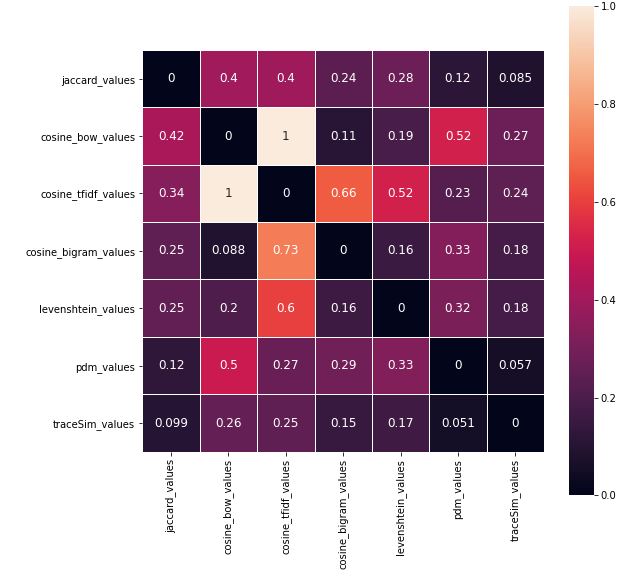

In [ ]:
threshold = 0.5
correlation_kld_matrix = matrix_correlation_kld(df_measures, 30, threshold)
columns = list(df_measures.columns[2:])
f, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(correlation_kld_matrix, vmin = 0, vmax=1, linewidths=.5, square=True, annot=True, xticklabels = columns, yticklabels = columns, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
plt.show()

Ur result must match:
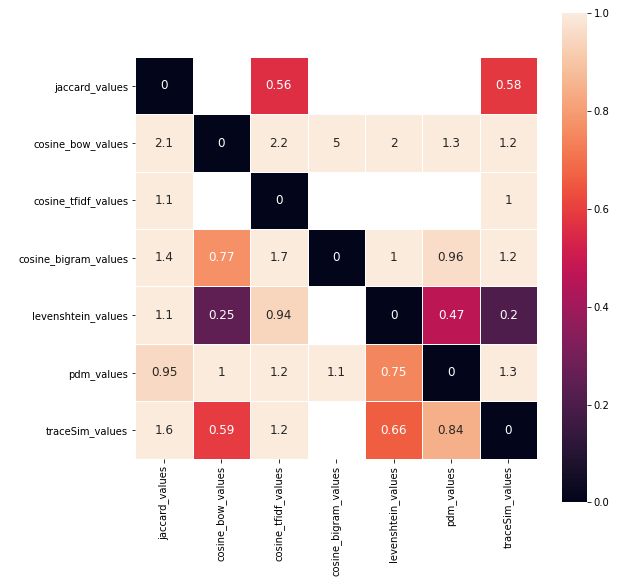

### C.1.2. Correlation of Pearson [[doc](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)]

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
def pearson_correlation (values1, values2):
    'Complete your code here ..................................'

def pearson_correlation_with_threshold (values1, values2, threshold):
    'Complete your code here ..................................'


def matrix_correlation_pearson(df_measures, threshold) :
    correlation_matrix = np.zeros((len(df_measures.columns)-2, len(df_measures.columns)-2), float)
    'Complete your code here ..................................'
    return correlation_matrix

In [ ]:
"The output must be ~ 0.95 "
pearson_correlation(df_measures['jaccard_values'], df_measures['cosine_bow_values'])[0]

In [ ]:
"The output must be ~ 0.93 "
pearson_correlation_with_threshold(df_measures['jaccard_values'], df_measures['cosine_bow_values'], 0.5)[0]

In [ ]:
threshold = 0.8
correlation_pearson_matrix = matrix_correlation_pearson(df_measures,threshold)
columns = list(df_measures.columns[2:])
f, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(correlation_pearson_matrix, vmin = 0, vmax=1, linewidths=.5, square=True, annot=True, xticklabels = columns, yticklabels = columns, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
plt.show()

Ur result must match:
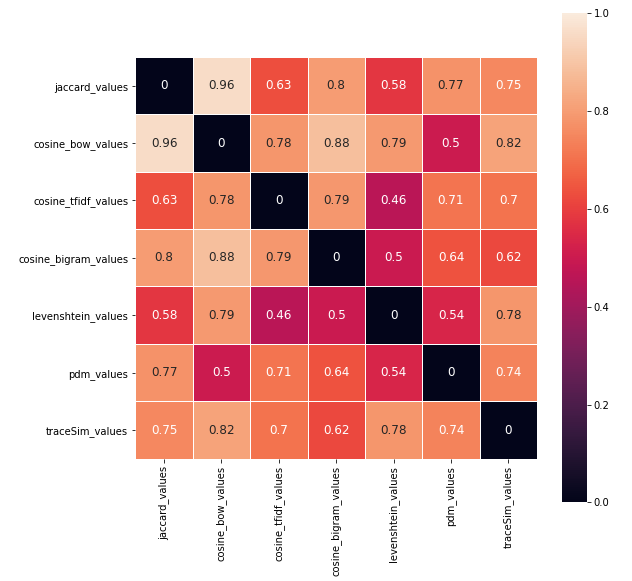

### <font color='red'> C.1.3. Correlation of ? (propose a ranking correlation metric that exists in the state of the art) </font>

#### <font color='blue'> Complete your own code here ...  </font> 

In [ ]:
'Change yourMeasure with the name of your measure'

def yourMeasure_correlation (values1, values2):
    'Complete your code here ..................................'


def yourMeasure_correlation_with_threshold (values1, values2, threshold):
    'Complete your code here ..................................'


def matrix_correlation_yourMeasure(df_measures, threshold) :
    correlation_matrix = np.zeros((len(df_measures.columns)-2, len(df_measures.columns)-2), float)
    'Complete your code here ..................................'
    return correlation_matrix

In [ ]:
threshold = 0.0
correlation_yourMeasure_matrix = matrix_correlation_yourMeasure(df_measures,threshold)
columns = list(df_measures.columns[2:])
f, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(correlation_yourMeasure_matrix, vmin = 0, vmax=1, linewidths=.5, square=True, annot=True, xticklabels = columns, yticklabels = columns, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
plt.show()

In [ ]:
threshold = 0.5
correlation_yourMeasure_matrix = matrix_correlation_yourMeasure(df_measures,threshold)
columns = list(df_measures.columns[2:])
f, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(correlation_yourMeasure_matrix, vmin = 0, vmax=1, linewidths=.5, square=True, annot=True, xticklabels = columns, yticklabels = columns, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
plt.show()

## C.2. Inspect individuel cases

### <font color='red'> For similarity measures that are not highly correlated display a scatter graph, then show the outlying individual cases and justify why, based on the properties of the similarity measures (take at least 3 cases)  </font>

In [ ]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.scatter(df_measures['levenshtein_values'], df_measures['pdm_values'], alpha=0.5)
plt.xlabel("Levenshtein")
plt.ylabel("PDM")
plt.plot([0,1],[0,1])
plt.plot([1,1],[0,1])
plt.plot([0,1],[1,1])
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.show()

In [ ]:
df_measures[(df_measures['levenshtein_values'] < 0.4) & (df_measures['pdm_values'] > 0.8)].sort_values(by='pdm_values')[['index_stack_trace_1','index_stack_trace_2','levenshtein_values','pdm_values']]

#### <font color='blue'> Complete explanation here ...  </font> 

## C.3. Properties of similarity measures

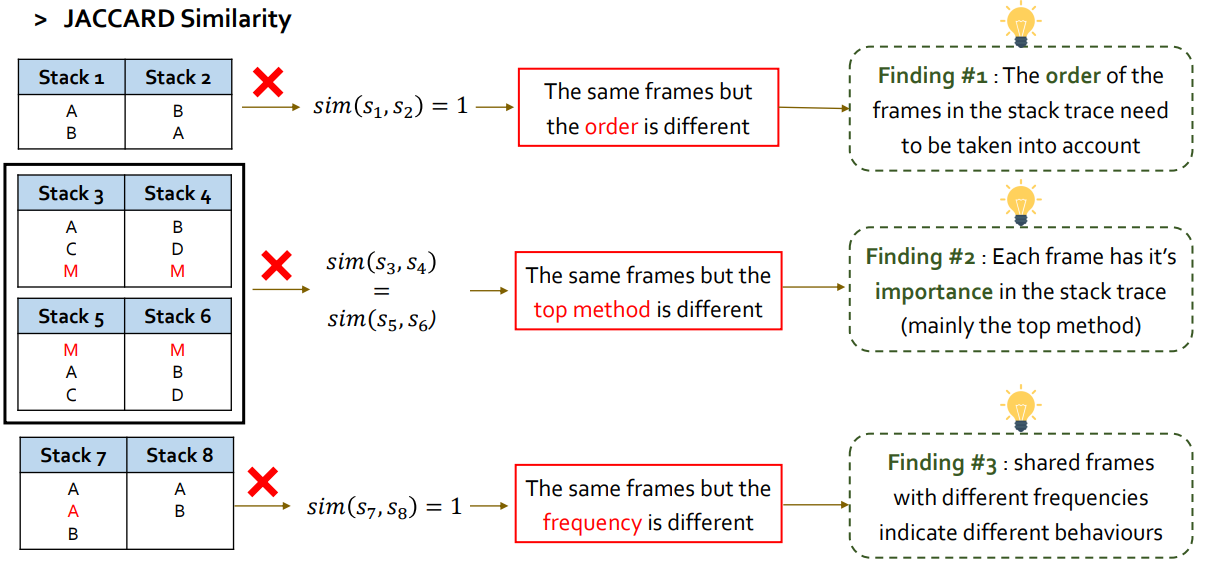

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

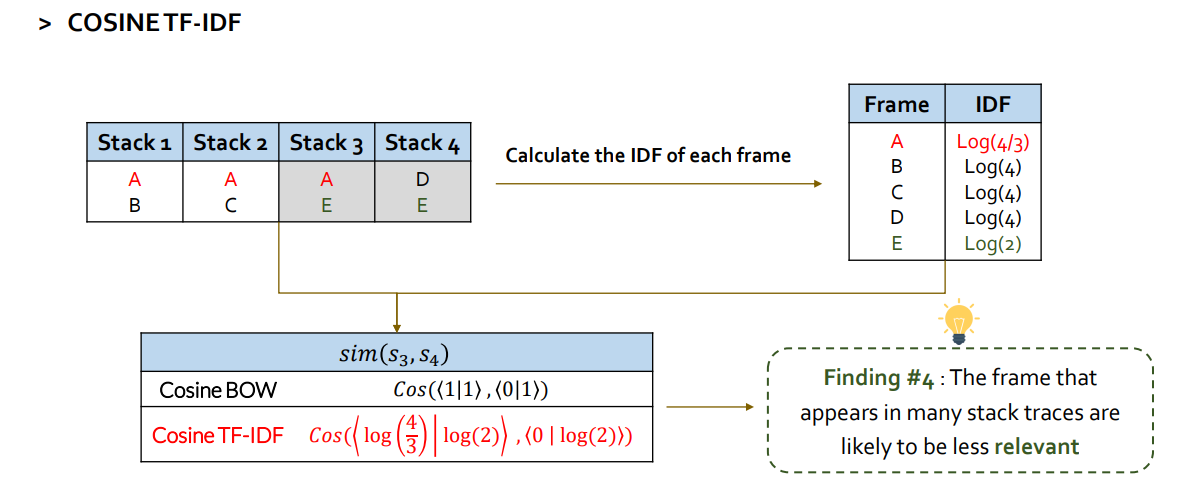

-----------------------------------------------------------

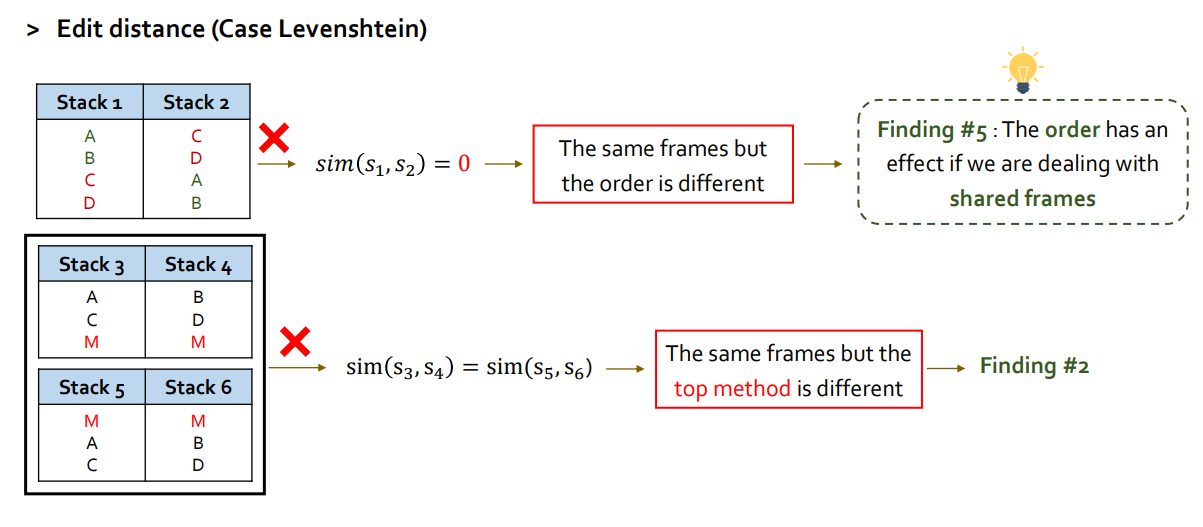

#### <font color='blue'> Complete comparison here ...  </font> 

#### **Based on these experiments, fill the following table**

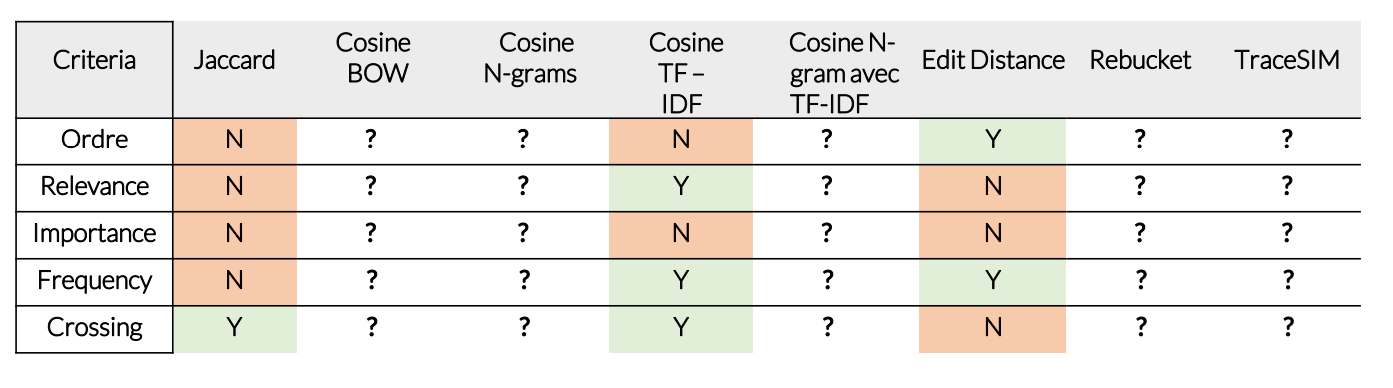